# Weapon usage trends v2

Calculations of weapon usage are based on weapon_kills/all_kills ratio for each player and round [as suggested by Fri](https://discord.com/channels/498800300199772162/977172055361470474/1063083053003583548). With this approach weapons that are getting less kills but more caps (eg m79) are treated more fairly compared to those that are good at getting high kill count (eg mp5, rheinmetall).

In [1]:
from s2_analytics.collect.fris_weapon_usage_collector import FriWeaponUsageCollector
from s2_analytics.filters import PLAYLIST_CTF, BALANCED
import pandas as pd
import seaborn as sns

from s2_analytics.collect.sqlite_collector import SqliteCollector
from s2_analytics.importer import import_games

sqlite_collector = SqliteCollector().init()
fri_collector = FriWeaponUsageCollector().init()
import_games("logs_ranked/", period_days=90, processors=[sqlite_collector, fri_collector], game_filters=[PLAYLIST_CTF])
con = sqlite_collector.connection
cur = con.cursor()
pass

## Data summary

In [2]:
query = """
    select
        datetime(min(id)/1000, 'unixepoch') first_game,
        datetime(max(id)/1000, 'unixepoch') last_game,
        count(1) games_count
    from game
"""
pd.read_sql_query(query, con)

,first_game,last_game,games_count
0,2022-12-15 23:19:05,2023-03-15 00:22:54,1197


In [3]:
query = """
    select
        playlistCode,
        count(1) games_count
    from game group by playlistCode
"""
pd.read_sql_query(query, con)

,playlistCode,games_count
0,CTF-Standard-2,25
1,CTF-Standard-4,28
2,CTF-Standard-6,1138
3,CTF-Standard-8,2
4,CTF-Test-2,4


## Primary weapons

Chart data: [csv](data/wu2_ra_21_DeaglesMP5SteyrAUGKalashnikovSpas12M79DragunovBarrettRocketLauncherRheinmetallMinigun.csv)

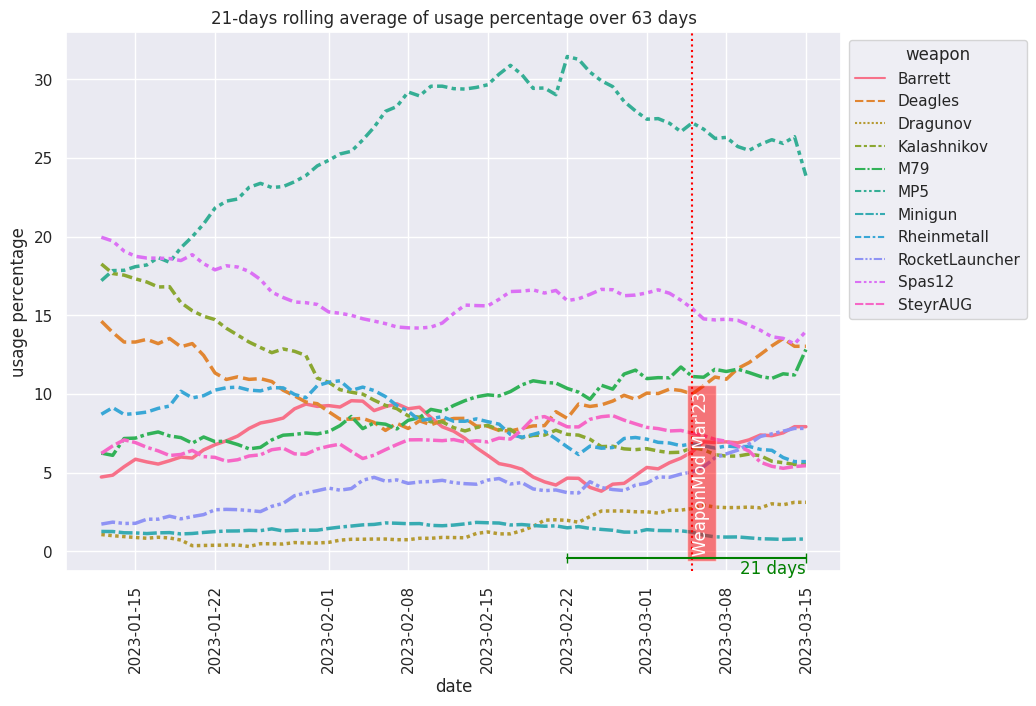

In [4]:

from datetime import timedelta
from matplotlib.lines import Line2D
from s2_analytics.tools import dump_csv
from s2_analytics.constants import WEAPONS_SECONDARY, WEAPONS_PRIMARY, WEAPON_MODS_DATES, WEAPON_MODS_CATALOG
from matplotlib.ticker import FixedLocator


def rolling_average_weapons_used(collector: FriWeaponUsageCollector, days: int, weapons_list, chart_height):
    visible_period = days * 3
    min_days_needed = int(days * 0.7)
    total_period = days * 3 + min_days_needed
    df = collector.get_data(weapons_list, days, min_days_needed, total_period)

    def generate_rolling_average_plot(df, days: int, chart_height):
        sns.set(rc={'figure.figsize': (10, chart_height)})
        plt = sns.lineplot(df, x="date", y=f"usage percentage", style="weapon", hue="weapon", linewidth=2.5)
        plt.xaxis.set_major_locator(FixedLocator(plt.get_xticks().tolist()))
        plt.set_xticklabels(plt.get_xticklabels(), rotation=90)
        plt.set_title(f"{days}-days rolling average of usage percentage over {visible_period} days")
        sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))

        # weaponmod marker
        chart_start_date = df["date"].min()
        for wm in WEAPON_MODS_CATALOG.wms:
            if wm.datetime > chart_start_date:
                plt.axvline(wm.datetime, color="red", linestyle="dotted", zorder=3)
                plt.text(wm.datetime, 0, f"{wm}", rotation=90, color="white",
                         bbox = dict(facecolor = 'red', alpha = 0.5), zorder=3)

        # average period marker
        max_date = df["date"].max()
        plt.add_line(Line2D([max_date - timedelta(days=days), max_date], [-0.4, -0.4], color="green", zorder=3, marker="|", markersize=7))
        plt.text(max_date, -0.5, f"{days} days", color="green", ha="right", va="top", zorder=3)


        return plt

    generate_rolling_average_plot(df, days, chart_height=chart_height)
    dump_csv(df, f"wu2_ra_{days}_{''.join(weapons_list)}")


rolling_average_weapons_used(fri_collector, 21, WEAPONS_PRIMARY, chart_height=7)
pass

Chart data: [csv](data/wu2_ra_7_DeaglesMP5SteyrAUGKalashnikovSpas12M79DragunovBarrettRocketLauncherRheinmetallMinigun.csv)

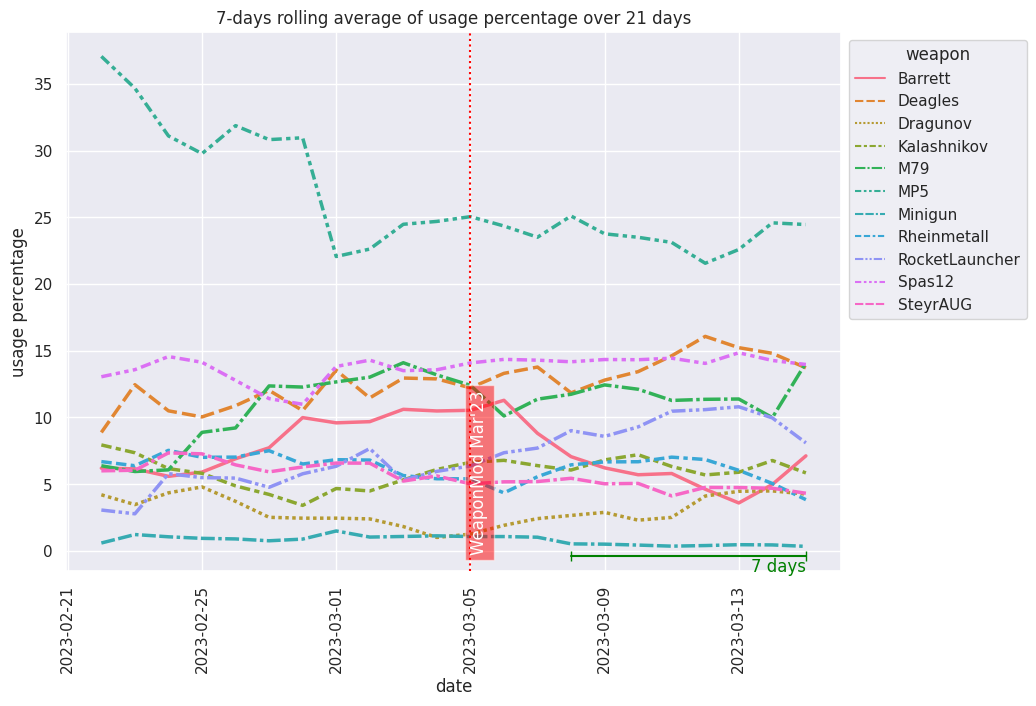

In [5]:
rolling_average_weapons_used(fri_collector, 7, WEAPONS_PRIMARY, chart_height=7)
pass

## Secondary weapons


Chart data: [csv](data/wu2_ra_21_ChainsawKnifeMakarovRPG.csv)

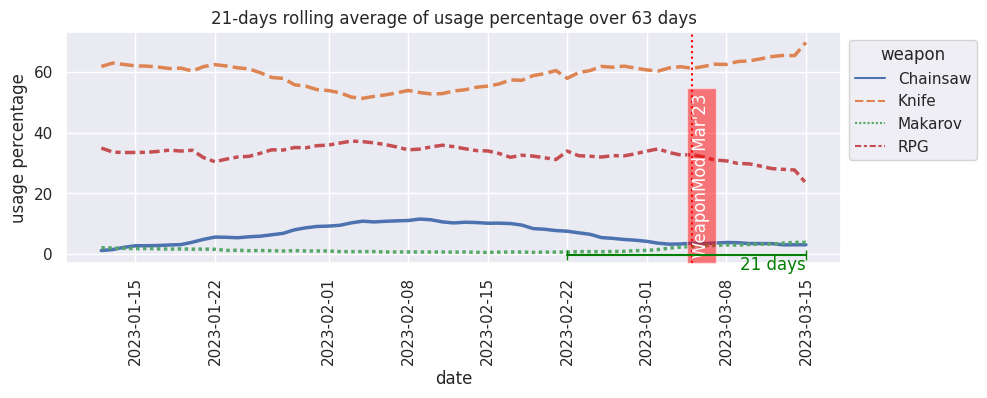

In [6]:
rolling_average_weapons_used(fri_collector, 21, WEAPONS_SECONDARY, chart_height=3)
pass

Chart data: [csv](data/wu2_ra_7_ChainsawKnifeMakarovRPG.csv)

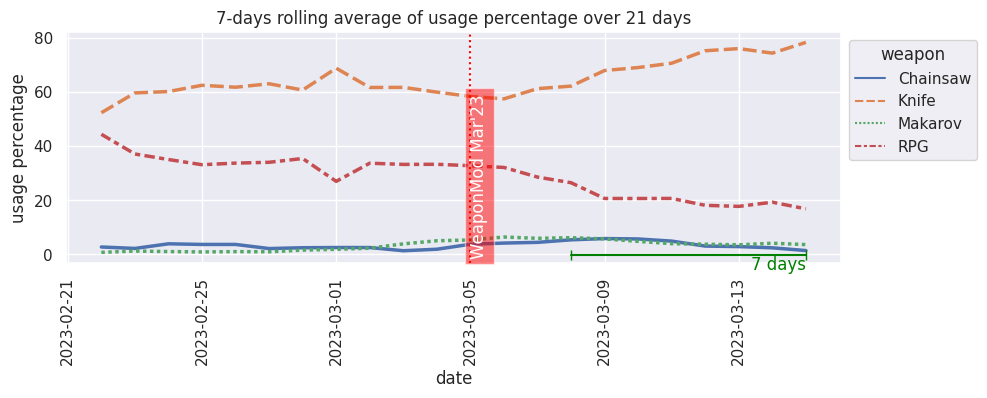

In [7]:
used = rolling_average_weapons_used(fri_collector, 7, WEAPONS_SECONDARY, chart_height=3)
pass